In [1]:
""" 
File to import and implement ARIMA models and different types of smoothing and lagging
"""

' \nFile to import and implement ARIMA models and different types of smoothing and lagging\n'

In [2]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import sklearn RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import MAE
from sklearn.metrics import mean_absolute_error

In [3]:
# Load data
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

df_prod_2_year_cons = pd.read_csv('data/year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('data/year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [4]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh_normalized']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [5]:
# Define a baseline function
def baseline_model(series, units_to_forecast, unit = "hours"):
    """Create baseline from series

    Args:
        series (pd.Series): series to create baseline from
        days_to_forecast (int): days to forecast

    Returns:
        pd.Series: Baseline forecast
    """

    if unit == "days":
        factor = 1
    if unit == "hours":
        factor = 24

    # For each day to forecast, get the value from the last week
    # Create series with index same as series
    baseline = pd.Series(index=series.index[-units_to_forecast+1:])
    # For each day to forecast
    for i in range(units_to_forecast-1):
        # Get the last week
        last_week = series.iloc[i-7*2*factor]
        # Add to baseline
        baseline[i] = last_week

    
    # Return forecast
    # invert the list
    return baseline

In [6]:
# Cut data to only use the first year
series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="prod",
                        start=None,
                        end=None,
                        agg="day")
print(series.head(10))

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh_normalized
timeslot                                     
2016-09-04 00:00:00+00:00            0.000000
2016-09-05 00:00:00+00:00            0.638889
2016-09-06 00:00:00+00:00            0.083333
2016-09-07 00:00:00+00:00            0.500000
2016-09-08 00:00:00+00:00            0.361111
2016-09-09 00:00:00+00:00            0.000000
2016-09-10 00:00:00+00:00            0.000000
2016-09-11 00:00:00+00:00            0.027778
2016-09-12 00:00:00+00:00            0.416667
2016-09-13 00:00:00+00:00            0.277778


In [7]:
# We can also just cheat and use pmdarima to get the best difference term
from pmdarima.arima import ndiffs, nsdiffs 

print(ndiffs(series))
print(nsdiffs(series, m=4*30))

1
0


In [11]:
#stolen from https://machinelearningmastery.com/random-forest-for-time-series-forecasting/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    print("Converting data to cool stuff")
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(int(n_in), 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, int(n_out)):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        print("dropping NaNs")
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    print("Splitting data set")
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=2)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

def alt_random_forest_forecast(train, testX, n_trees, max_features):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=int(n_trees), max_features=max_features)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        print("Fitting to RF-model ",i)
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        print('>expected=%.3f, predicted=%.3f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

def alt_walk_forward_validation(data, n_test, n_trees, max_features):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        print("Fitting to RF-model ",i)
        yhat = alt_random_forest_forecast(history, testX, n_trees, max_features)
        # store forecast in list of predictions
        predictions.append(yhat)
        print('>expected=%.3f, predicted=%.3f' % (testy, yhat))
    # estimate prediction error
    error = (np.sum(np.square(np.asarray(test[:, -1])-np.asarray(predictions))))/n_test
    print("Mean squared error is {}".format(error))
    return error, test[:, -1], predictions

def RF_method(series, backwardshifts, forwardshifts, n_test, n_trees, max_features):
    values = series.to_numpy()
    data = series_to_supervised(values, n_in=backwardshifts,n_out=forwardshifts,dropnan=True)
    print("backwardshifts={}, forwardshifts={}, n_trees={}".format(backwardshifts,forwardshifts,n_trees))
    error, y, yhat = alt_walk_forward_validation(data, n_test, n_trees, max_features)
    return error, y, yhat
    

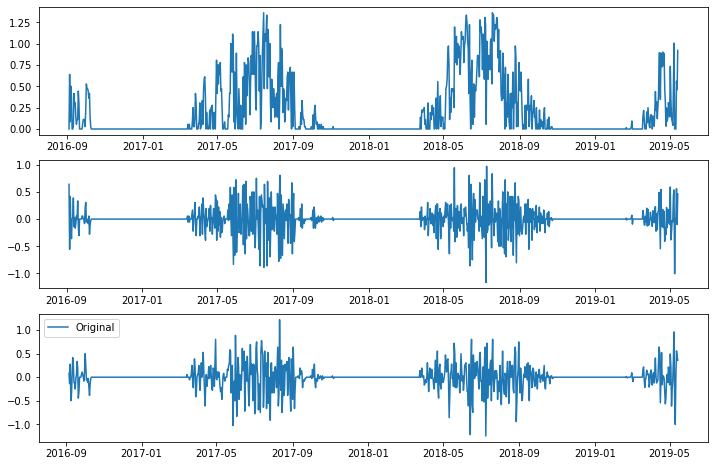

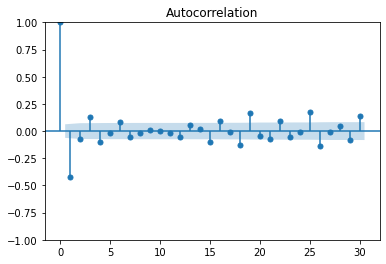

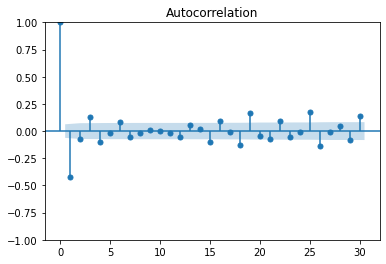

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import make_subplots

series_1_diff = series.diff().dropna()
series_2_diff = series.diff(2).dropna()

# make matplotlib subplots for plotting series_1_diff and series_2_diff
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
ax1.plot(series)
ax2.plot(series_1_diff)
ax3.plot(series_2_diff)
plt.legend(['Original', '1st Diff', '2nd Diff'])

plt.show()

plot_acf(series_1_diff)

We see that the series is stationary when doing a single difference

Converting data to cool stuff
dropping NaNs
backwardshifts=1, forwardshifts=400, n_trees=100
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.027
Fitting to RF-model  1
>expected=0.560, predicted=0.139
Fitting to RF-model  2
>expected=-0.101, predicted=-0.165
Fitting to RF-model  3
>expected=0.461, predicted=-0.027
Mean squared error is 0.10503575489191738


C:\Users\alexa\AppData\Local\Temp\ipykernel_24340\218622584.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline = pd.Series(index=series.index[-units_to_forecast+1:])


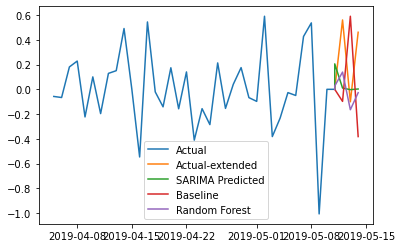

In [13]:
# Fit model

# ARIMA MODEL EXPLAINED
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

train_series = series_1_diff

units_to_forecast = 4

AR = 1
I = 0
MA = 1

P = 1
D = 0
Q = 1
M = 4*30

# SARIMA
ARIMA_order = (AR, I, MA)
SEASONAL_order = (P, D, Q, M)

sarima_model = SARIMAX(train_series[:-units_to_forecast], order=ARIMA_order, seasonal_order=SEASONAL_order)
sarima_model_fit = sarima_model.fit()
sarima_forecast = sarima_model_fit.forecast(steps=units_to_forecast)

# RANDOM FOREST
#df_mm_prod = df_prod[df_prod["meter_id"] == "28ba7f57-6e83-4341-8078-232c1639e4e3"]
#df_mm_prod = df_mm_prod[df_mm_prod["type"] == "production"]
#df_mm_prod.index = pd.to_datetime(df_mm_prod["timeslot"], utc=True)

# transform the time series data into supervised learning
error, y, yhat = RF_method(train_series, 1, 400, units_to_forecast, 100, 100)
rf_forecast = pd.Series(yhat, index = train_series[-units_to_forecast:].index)

# ACTUAL
actual = train_series[-units_to_forecast*10:-units_to_forecast+1]
actual2 = train_series[-units_to_forecast:]

# BASELINE
baseline_forecast = baseline_model(train_series, units_to_forecast, unit = "days")

# Add the last value of the actual series to the first value of the forecast and baseline
sarima_forecast = pd.concat([pd.Series(actual.iloc[-1].values[0], index = [actual.index[-1]]), sarima_forecast])
baseline_forecast = pd.concat([pd.Series(actual.iloc[-1].values[0], index = [actual.index[-1]]), baseline_forecast])
rf_forecast = pd.concat([pd.Series(actual.iloc[-1].values[0], index=[actual.index[-1]]),rf_forecast])

# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(actual2, label="Actual-extended")
plt.plot(sarima_forecast, label="SARIMA Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.plot(rf_forecast, label="Random Forest")
plt.legend()
plt.show()

# Bayesian optimization for tuning hyperparameters for Random Forest

In [25]:
import GPyOpt
from GPyOpt.methods import BayesianOptimization

# define the dictionary for GPyOpt
## define the domain of the considered parameters
backwardshifts = tuple(np.arange(1,400,1, dtype = np.int))
forwardshifts = tuple(np.arange(1,500,1, dtype = np.int))
n_trees = tuple(np.arange(2,700,1, dtype = np.int))
#max_features = tuple(np.arange(0.51,1.0,0.01, dtype = np.float64))


domain = [{'name': 'backwardshifts', 'type': 'discrete', 'domain': backwardshifts},
          {'name': 'forwardshifts', 'type': 'discrete', 'domain': forwardshifts},
          {'name': 'n_trees', 'type': 'discrete', 'domain': n_trees}]

def objective_function(x):
    param = x[0]
    error, y, yhat = RF_method(train_series, param[0], param[1], units_to_forecast, param[2], 1.0)
    return error



In [26]:
opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = 'EI' ,      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 50) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: backwardshifts=" + str(x_best[0]) + ", forwardshifts=" + str(x_best[1]) + ", n_trees=" + str(
    x_best[2]))

Converting data to cool stuff
dropping NaNs
backwardshifts=129.0, forwardshifts=307.0, n_trees=628.0
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.015
Fitting to RF-model  1
>expected=0.560, predicted=0.134
Fitting to RF-model  2
>expected=-0.101, predicted=-0.184
Fitting to RF-model  3
>expected=0.461, predicted=-0.058
Mean squared error is 0.11450975955022466
Converting data to cool stuff
dropping NaNs
backwardshifts=166.0, forwardshifts=166.0, n_trees=569.0
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.056
Fitting to RF-model  1
>expected=0.560, predicted=0.157
Fitting to RF-model  2
>expected=-0.101, predicted=-0.207
Fitting to RF-model  3
>expected=0.461, predicted=-0.279
Mean squared error is 0.18097603614477137
Converting data to cool stuff
dropping NaNs
backwardshifts=172.0, forwardshifts=210.0, n_trees=690.0
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.057
Fitting to RF-model  1
>expected=0.560, predic

>expected=0.000, predicted=-0.029
Fitting to RF-model  1
>expected=0.560, predicted=0.190
Fitting to RF-model  2
>expected=-0.101, predicted=-0.190
Fitting to RF-model  3
>expected=0.461, predicted=0.024
Mean squared error is 0.08394804906823924
Converting data to cool stuff
dropping NaNs
backwardshifts=319, forwardshifts=382, n_trees=95
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.016
Fitting to RF-model  1
>expected=0.560, predicted=0.094
Fitting to RF-model  2
>expected=-0.101, predicted=-0.153
Fitting to RF-model  3
>expected=0.461, predicted=0.072
Mean squared error is 0.09293734183090516
Converting data to cool stuff
dropping NaNs
backwardshifts=285, forwardshifts=364, n_trees=98
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=-0.018
Fitting to RF-model  1
>expected=0.560, predicted=0.055
Fitting to RF-model  2
>expected=-0.101, predicted=-0.100
Fitting to RF-model  3
>expected=0.461, predicted=0.012
Mean squared error is 0.114101334

Converting data to cool stuff
dropping NaNs
backwardshifts=374, forwardshifts=347, n_trees=5
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=-0.120
Fitting to RF-model  1
>expected=0.560, predicted=0.067
Fitting to RF-model  2
>expected=-0.101, predicted=-0.002
Fitting to RF-model  3
>expected=0.461, predicted=-0.081
Mean squared error is 0.14037314576388882
Converting data to cool stuff
dropping NaNs
backwardshifts=384, forwardshifts=308, n_trees=2
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.164
Fitting to RF-model  1
>expected=0.560, predicted=0.082
Fitting to RF-model  2
>expected=-0.101, predicted=0.073
Fitting to RF-model  3
>expected=0.461, predicted=0.268
Mean squared error is 0.08079893639081781
Converting data to cool stuff
dropping NaNs
backwardshifts=354, forwardshifts=343, n_trees=23
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=-0.037
Fitting to RF-model  1
>expected=0.560, predicted=0.157
Fitting to RF

Converting data to cool stuff
dropping NaNs
backwardshifts=379.0, forwardshifts=339.0, n_trees=2.0
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.295
Fitting to RF-model  1
>expected=0.560, predicted=0.184
Fitting to RF-model  2
>expected=-0.101, predicted=0.153
Fitting to RF-model  3
>expected=0.461, predicted=-0.217
Mean squared error is 0.1880810648630401


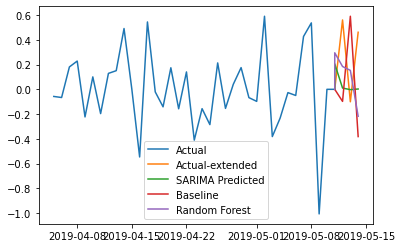

In [27]:
error, y, yhat = RF_method(train_series, x_best[0], x_best[1], units_to_forecast, x_best[2], 1.0)
rf_forecast2 = pd.Series(yhat, index = train_series[-units_to_forecast:].index)
rf_forecast2 = pd.concat([pd.Series(actual.iloc[-1].values[0], index=[actual.index[-1]]),rf_forecast2])


# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(actual2, label="Actual-extended")
plt.plot(sarima_forecast, label="SARIMA Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.plot(rf_forecast2, label="Random Forest")
plt.legend()
plt.show()

Feel like there was a better candidate among the points, so imma try that one too \[Dated\]

Converting data to cool stuff
dropping NaNs
backwardshifts=305, forwardshifts=367, n_trees=246
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=-0.015
Fitting to RF-model  1
>expected=0.560, predicted=0.114
Fitting to RF-model  2
>expected=-0.101, predicted=-0.122
Fitting to RF-model  3
>expected=0.461, predicted=0.037
Mean squared error is 0.09475898434765662


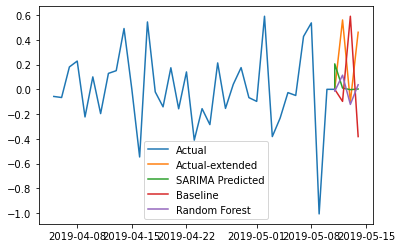

In [17]:
error, y, yhat = RF_method(train_series, 305, 367, units_to_forecast, 246, 1.0)
rf_forecast3 = pd.Series(yhat, index = train_series[-units_to_forecast:].index)
rf_forecast3 = pd.concat([pd.Series(actual.iloc[-1].values[0], index=[actual.index[-1]]),rf_forecast3])


# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(actual2, label="Actual-extended")
plt.plot(sarima_forecast, label="SARIMA Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.plot(rf_forecast3, label="Random Forest")
plt.legend()
plt.show()

Converting data to cool stuff
dropping NaNs
backwardshifts=1, forwardshifts=499, n_trees=2
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=0.340
Fitting to RF-model  1
>expected=0.560, predicted=0.309
Fitting to RF-model  2
>expected=-0.101, predicted=-0.361
Fitting to RF-model  3
>expected=0.461, predicted=0.228
Mean squared error is 0.07526479899691355


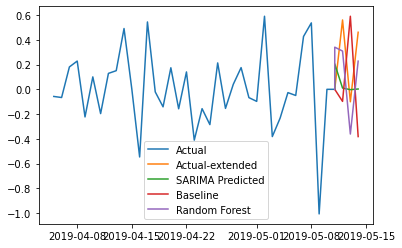

In [21]:
#this one occasionally does very well, but due to the low number of trees, it is not consistent
error, y, yhat = RF_method(train_series, 1, 499, units_to_forecast, 2, 1.0)
rf_forecast4 = pd.Series(yhat, index = train_series[-units_to_forecast:].index)
rf_forecast4 = pd.concat([pd.Series(actual.iloc[-1].values[0], index=[actual.index[-1]]),rf_forecast4])


# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(actual2, label="Actual-extended")
plt.plot(sarima_forecast, label="SARIMA Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.plot(rf_forecast4, label="Random Forest")
plt.legend()
plt.show()

Converting data to cool stuff
dropping NaNs
backwardshifts=379, forwardshifts=339, n_trees=2
Splitting data set
Fitting to RF-model  0
>expected=0.000, predicted=-0.028
Fitting to RF-model  1
>expected=0.560, predicted=0.352
Fitting to RF-model  2
>expected=-0.101, predicted=-0.209
Fitting to RF-model  3
>expected=0.461, predicted=0.108
Mean squared error is 0.045016461612654324


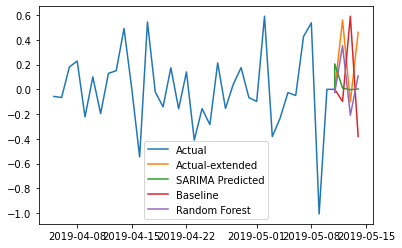

In [48]:
#couldn't wait
error, y, yhat = RF_method(train_series, 379, 339, units_to_forecast, 2, 1.0)
rf_forecast5 = pd.Series(yhat, index = train_series[-units_to_forecast:].index)
rf_forecast5 = pd.concat([pd.Series(actual.iloc[-1].values[0], index=[actual.index[-1]]),rf_forecast5])


# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(actual2, label="Actual-extended")
plt.plot(sarima_forecast, label="SARIMA Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.plot(rf_forecast5, label="Random Forest")
plt.legend()
plt.show()

Okay, so i'm gonna redo the hyperparameter tuning for just Random Forest in a new python notebook, cuz this is getting crowded and stupid, plus there's a bunch of silly mistakes in this so it's easier to just start over.